### Архитектура Unet

**Черкасов Борис**

В рамках сдачи финального проекта по специализации "Машинное обучение" от Яндекса предлагается командам из 4 человек создать архитектуру, которая будет эффективно классифицировать изображения с людьми, занятыми различными активностями.

Предлагается реализовать архитектуру, похожую на Unet и протестировать ее с различными гиперпараметрами, слоями, преобразованиями для оценки ее классификации.

Ссылка на проект: [ML intensive Yandex Academy autumn 2024](https://www.kaggle.com/competitions/ml-intensive-yandex-academy-autumn-2024/overview)

***Описание задания***:

В этом соревновании нужно написать сверточную нейронную сеть для классификации изображений.

Вам предоставлен датасет с фотографиями людей, занятых различными активностями:

* sports
* occupation
* conditioning exercise
* home activities
* lawn and garden
* home repair
* water activities
* winter activities
* miscellaneous
* fishing and hunting
* dancing
* walking
* music playing
* bicycling
* running
* inactivity quiet/light

Размер обучающей выборки (train) - 12 тысяч изображений, тестовой выборки (test) - 5 тысяч изображений.

В данном домашнем задании нет никаких ограничений по архитектуре модели, но реализовывать в pytorch/tensorflow её надо самим и обучить с нуля только на данном датасете, без внешних данных.

Оценка происходит по следующей метрике:

$f_1 = \frac{2 \cdot precison \cdot recall}{precison + recall}$


1) Загружаем данные, предварительно скачав их и подготовив к обучению модели.
2) Реализовываем модель типа Unet.
3) Проводим обучение и предсказание.

***1. Подготовка данных***

In [5]:
# Подключаем необходимые библиотеки

import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [6]:
# Определяем гиперпараметры

batch_size = 32
num_epochs = 10
lr = 0.001
device = "cpu"

# Для transform

size = (64, 64)


if torch.cuda.is_available():
    device = torch.cuda

In [7]:
# Путь к данным

data_dir = "../human_poses_data"
train_dir = os.path.join(data_dir, "img_train")
test_dir = os.path.join(data_dir, "img_test")
train_labels_path = os.path.join(data_dir, "train_answers.csv")

# Чтение файла с метками
train_labels = pd.read_csv(train_labels_path)

train_labels['target_feature'].max()

FileNotFoundError: [Errno 2] No such file or directory: '../human_poses_data\\train_answers.csv'

In [ ]:
# Произведем пребразования над данными для последующей их передачи в модель

transform_train = transforms.Compose([
    transforms.Resize(size=size), # Уменьшаем и приводим изображения к одному размеру
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize(size=size), # Уменьшаем и приводим изображения к одному размеру
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
# Определим удобный класс Dataset для хранения данных

class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, labels_df=None, transform=None):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        self.img_files = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.labels_df) if self.labels_df is not None else len(os.listdir(self.img_dir))
    
    def __getitem__(self, index):
        img_name = self.img_files[index]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.labels_df is not None:
            img_id = int(os.path.splitext(img_name)[0])
            label = self.labels_df.loc[self.labels_df["img_id"] == img_id, "target_feature"].values[0]
            return image, label
        else:
            return image, img_name

NameError: name 'Dataset' is not defined

In [ ]:
# Создаем DataLoader

train_dataset = HumanPoseDataset(train_dir, train_labels, transform=transform_train)
test_dataset = HumanPoseDataset(test_dir, transform=transform_train)

# Разделяем обучающий датасет на валидационную и обучающую выборки
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

***2. Определяем класс модели***

Возьмем односверточную и посмотрим на результаты.

In [ ]:
# Определяем класс SimpleUnet, в дальнейшем будем добавлены новые слои

class SimpleUNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleUNet, self).__init__()
        
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Декодер
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU()
        )

        # Классификатор 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 128 * 128 // 4, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.classifier(x)
        return x

In [ ]:
# Выведем summary модели
num_classes = len(range(train_labels["target_feature"].min(), train_labels["target_feature"].max()))
print("Кол-во классов:", num_classes)

unet = SimpleUNet(num_classes=num_classes + 1).to(device)
print(unet)

Кол-во классов: 18
SimpleUNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=19, bias=True)
  )
)


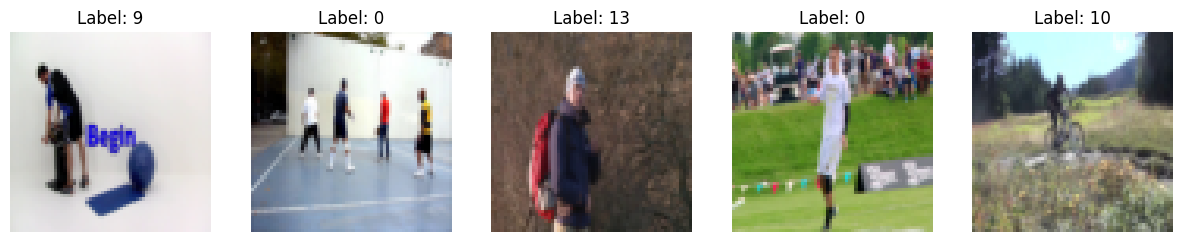

In [ ]:
# Посмотрим на картинки в обучающей выборке

# Функция для печатания картинок из датасета
def show_images(dataset, num_images=5):
    """Функция для отображения нескольких изображений из датасета"""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]  # Получаем изображение и метку
        image = image.permute(1, 2, 0).numpy()  # Меняем порядок осей для отображения
        image = (image * 0.5 + 0.5)  # Обратно нормализуем для отображения (если нормализовали)
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.show()

# Покажем несколько изображений из обучающего набора
show_images(train_dataset, num_images=5)

***3. Обучение, предсказание, построение графиков и подсчет метрик***

In [ ]:
# Функция обучения и оценки 
def train_and_evaluate(model, train_loader, val_loader, num_epochs, lr): 
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr) 
    train_losses, val_losses = [], [] 
    val_metrics = [] 

    for epoch in range(num_epochs): 
        # Обучение 
        model.train() 
        train_loss = 0 
        for images, labels in train_loader: 
            images, labels = images.to(device), labels.to(device) 

            optimizer.zero_grad() 
            outputs = model(images) 
            loss = criterion(outputs, labels) 
            loss.backward() 
            optimizer.step() 

            train_loss += loss.item() 

        train_loss /= len(train_loader) 
        train_losses.append(train_loss) 
        
        # Оценка 
        model.eval() 
        val_loss = 0
        all_preds = [] 
        all_labels = [] 
        with torch.no_grad(): 
            for images, labels in val_loader: 
                images, labels = images.to(device), labels.to(device) 
                outputs = model(images)
                loss = criterion(outputs, labels) 
                val_loss += loss.item()
            
                preds = torch.argmax(outputs, dim=1) 
                all_preds.extend(preds.cpu().numpy()) 
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss) 
        
        acc = accuracy_score(all_labels, all_preds) 
        prec = precision_score(all_labels, all_preds, average="weighted") 
        rec = recall_score(all_labels, all_preds, average="weighted") 
        f1 = f1_score(all_labels, all_preds, average="weighted") 
        val_metrics.append((acc, prec, rec, f1)) 
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val Acc: {acc:.4f}, Val Prec: {prec:.4f}, Val Recall: {rec:.4f}, Val F1: {f1:.4f}") 
        
    return train_losses, val_losses, val_metrics

In [ ]:
# Функция для предсказания и сохранения результатов
def predict_and_save(model, test_loader, output_file):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in test_loader:  # img_name_batch нам не нужен для индексации
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)

    # Создаем DataFrame с индексами и предсказаниями
    results_df = pd.DataFrame({
        "id": range(len(predictions)),  # Порядковый номер объекта в датасете
        "target_feature": predictions
    })

    # Сохраняем файл в формате CSV
    results_df.to_csv(output_file, index=False)
    print(f"Предсказания сохранены в файл {output_file}")

In [ ]:
# Запуск обучения и валидации. Пример, чтобы посмотреть на изменение
train_losses, val_losses, val_metrics = train_and_evaluate(unet, train_loader, val_loader, num_epochs=10, lr=lr) 

# После обучения производим предсказания и сохраняем их в требуемый формат
output_file = "test_predictions.csv"
predict_and_save(unet, test_loader, output_file) 

Epoch 1/10, Train Loss: 0.0622, Val Loss: 3.8297, Val Acc: 0.4703, Val Prec: 0.5005, Val Recall: 0.4703, Val F1: 0.4611
Epoch 2/10, Train Loss: 0.0469, Val Loss: 3.4751, Val Acc: 0.4832, Val Prec: 0.4822, Val Recall: 0.4832, Val F1: 0.4731
Epoch 3/10, Train Loss: 0.0230, Val Loss: 4.1681, Val Acc: 0.4691, Val Prec: 0.4973, Val Recall: 0.4691, Val F1: 0.4596
Epoch 4/10, Train Loss: 0.0535, Val Loss: 4.1866, Val Acc: 0.4505, Val Prec: 0.4658, Val Recall: 0.4505, Val F1: 0.4459
Epoch 5/10, Train Loss: 0.0505, Val Loss: 4.2226, Val Acc: 0.4634, Val Prec: 0.4692, Val Recall: 0.4634, Val F1: 0.4525
Epoch 6/10, Train Loss: 0.0269, Val Loss: 4.3485, Val Acc: 0.4691, Val Prec: 0.4796, Val Recall: 0.4691, Val F1: 0.4626
Epoch 7/10, Train Loss: 0.0401, Val Loss: 4.1939, Val Acc: 0.4687, Val Prec: 0.4721, Val Recall: 0.4687, Val F1: 0.4638
Epoch 8/10, Train Loss: 0.0223, Val Loss: 4.2929, Val Acc: 0.4654, Val Prec: 0.4800, Val Recall: 0.4654, Val F1: 0.4636
Epoch 9/10, Train Loss: 0.0169, Val Loss

In [ ]:
# Функция для визуализации графика ошибок и метрик
def visualize_model_results(train_losses, val_losses, val_metrics):
    val_acc = [m[0] for m in val_metrics] 
    val_f1 = [m[3] for m in val_metrics]

    plt.figure(figsize=(12, 6)) 
    plt.subplot(1, 2, 1) 
    plt.plot(range(0, 10), train_losses, label="Train Loss")
    plt.plot(range(0, 10), val_losses, label="Val Loss")
    plt.xlabel("Epoch") 
    plt.ylabel("Loss") 
    plt.title("Training Loss") 
    plt.legend() 

    plt.subplot(1, 2, 2) 
    plt.plot(val_acc, label="Validation Accuracy") 
    plt.plot(val_f1, label="Validation F1-Score") 
    plt.xlabel("Epoch") 
    plt.ylabel("Value") 
    plt.title("Validation Metrics") 
    plt.legend() 

    plt.tight_layout() 
    plt.show()

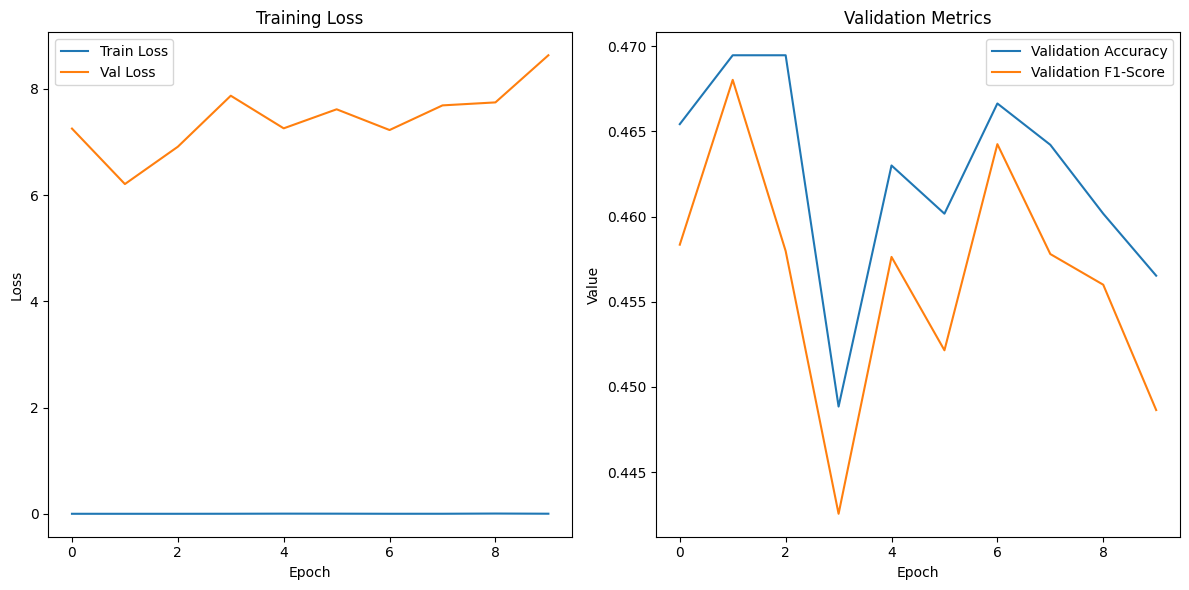

In [ ]:
# Визуализация

visualize_model_results(train_losses, val_losses, val_metrics)

In [ ]:
# Функция для сохранения результатов в лог файл
def save_log_model_results(file_name, train_losses, val_losses, val_metrics):
    """
    Сохраняет результаты обучения модели в лог-файл.

    Parameters:
        file_name (str): название файла для сохранения логов.
        train_losses (list, ndarray): список значений ошибки на обучающей выборке.
        val_lossses (list, ndarray): список значений ошибки на валидационной выборке.
        val_metrics (list, ndarray): метрики валидаций
    """

    with open(file_name, "w") as f:
        f.write("Training Results Log\n")
        f.write("=" * 50 + "\n")
        f.write(f"Total Epochs: {len(train_losses)}\n\n")
        
        f.write("Epoch-wise Results:\n")
        for epoch, (train_loss, val_loss, metrics) in enumerate(zip(train_losses, val_losses, val_metrics), start=1):
            acc, prec, rec, f1 = metrics
            f.write(
                f"Epoch {epoch}:\n"
                f"  Train Loss: {train_loss:.4f}\n"
                f"  Val Loss: {val_loss:.4f}\n"
                f"  Val Accuracy: {acc:.4f}\n"
                f"  Val Precision: {prec:.4f}\n"
                f"  Val Recall: {rec:.4f}\n"
                f"  Val F1-Score: {f1:.4f}\n\n"
            )
        f.write("=" * 50 + "\n")
    print(f"Лог результатов сохранен в файл {file_name}")

In [ ]:
# Сохраняем результаты первого теста архитектуры
save_log_model_results("unet_base_32.log", train_losses, val_losses, val_metrics )

Лог результатов сохранен в файл unet_base_32.log


**Теперь создадим перебор гиперапараметров для архитектуры, чтобы сравнить и найти лучшие**

*По мере тестирования будем сохранять результаты в лог файлы*

In [ ]:
# Изменим разер батчей на 64 и загрузим данные

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Запуск обучения с 64 батчами. Пример, чтобы посмотреть на изменение
train_losses, val_losses, val_metrics = train_and_evaluate(unet, train_loader, val_loader, num_epochs=10, lr=lr) 

# Сохранение предсказаний
output_file = "test_predictions_image64.csv"
predict_and_save(unet, test_loader, output_file)

Epoch 1/10, Train Loss: 0.0107, Val Loss: 5.9977, Val Acc: 0.4687, Val Prec: 0.4876, Val Recall: 0.4687, Val F1: 0.4611
Epoch 2/10, Train Loss: 0.0135, Val Loss: 5.1875, Val Acc: 0.4658, Val Prec: 0.4817, Val Recall: 0.4658, Val F1: 0.4608
Epoch 3/10, Train Loss: 0.0283, Val Loss: 5.7862, Val Acc: 0.4590, Val Prec: 0.4940, Val Recall: 0.4590, Val F1: 0.4582
Epoch 4/10, Train Loss: 0.0156, Val Loss: 5.0290, Val Acc: 0.4735, Val Prec: 0.4696, Val Recall: 0.4735, Val F1: 0.4653
Epoch 5/10, Train Loss: 0.0075, Val Loss: 5.6168, Val Acc: 0.4553, Val Prec: 0.4532, Val Recall: 0.4553, Val F1: 0.4470
Epoch 6/10, Train Loss: 0.0076, Val Loss: 5.4753, Val Acc: 0.4626, Val Prec: 0.4628, Val Recall: 0.4626, Val F1: 0.4554
Epoch 7/10, Train Loss: 0.0056, Val Loss: 4.6070, Val Acc: 0.4674, Val Prec: 0.4715, Val Recall: 0.4674, Val F1: 0.4662
Epoch 8/10, Train Loss: 0.0057, Val Loss: 4.5512, Val Acc: 0.4703, Val Prec: 0.4717, Val Recall: 0.4703, Val F1: 0.4643
Epoch 9/10, Train Loss: 0.0042, Val Loss

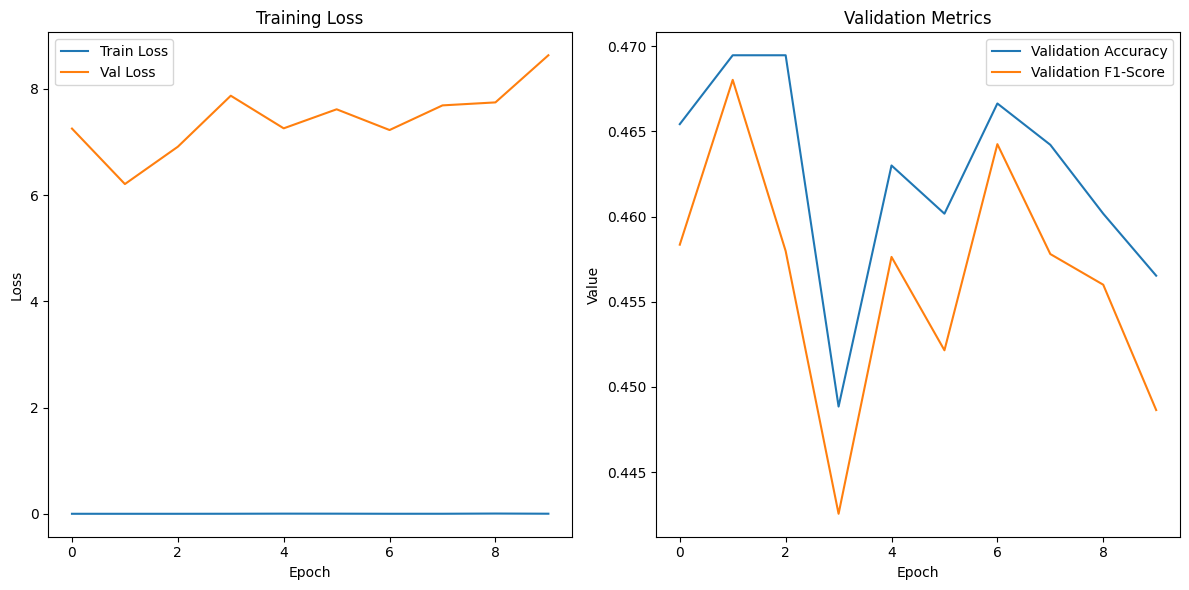

In [ ]:
# Визуализация

visualize_model_results(train_losses, val_losses, val_metrics)

In [ ]:
# Сохраняем результаты первого теста архитектуры с batch_size = 64
save_log_model_results("unet_base_batch_64_size.log", train_losses, val_losses, val_metrics)

Лог результатов сохранен в файл unet_base_batch_64_size.log


In [ ]:
# Теперь с 128 батчами.

batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Запуск обучения с 128 батчами. Пример, чтобы посмотреть на изменение
train_losses, val_losses, val_metrics = train_and_evaluate(unet, train_loader, val_loader, num_epochs=10, lr=lr) 

# Сохранение предсказаний
output_file = "test_predictions_image128.csv"
predict_and_save(unet, test_loader, output_file)

Epoch 1/10, Train Loss: 0.0013, Val Loss: 6.3375, Val Acc: 0.4844, Val Prec: 0.4797, Val Recall: 0.4844, Val F1: 0.4749
Epoch 2/10, Train Loss: 0.0043, Val Loss: 7.4087, Val Acc: 0.4622, Val Prec: 0.4738, Val Recall: 0.4622, Val F1: 0.4463
Epoch 3/10, Train Loss: 0.0118, Val Loss: 7.1495, Val Acc: 0.4679, Val Prec: 0.4797, Val Recall: 0.4679, Val F1: 0.4612
Epoch 4/10, Train Loss: 0.0117, Val Loss: 7.3355, Val Acc: 0.4658, Val Prec: 0.4750, Val Recall: 0.4658, Val F1: 0.4601
Epoch 5/10, Train Loss: 0.0025, Val Loss: 7.8663, Val Acc: 0.4581, Val Prec: 0.4649, Val Recall: 0.4581, Val F1: 0.4509
Epoch 6/10, Train Loss: 0.0012, Val Loss: 7.5632, Val Acc: 0.4594, Val Prec: 0.4655, Val Recall: 0.4594, Val F1: 0.4567
Epoch 7/10, Train Loss: 0.0021, Val Loss: 7.1935, Val Acc: 0.4610, Val Prec: 0.4593, Val Recall: 0.4610, Val F1: 0.4557
Epoch 8/10, Train Loss: 0.0016, Val Loss: 6.9093, Val Acc: 0.4561, Val Prec: 0.4544, Val Recall: 0.4561, Val F1: 0.4513
Epoch 9/10, Train Loss: 0.0006, Val Loss

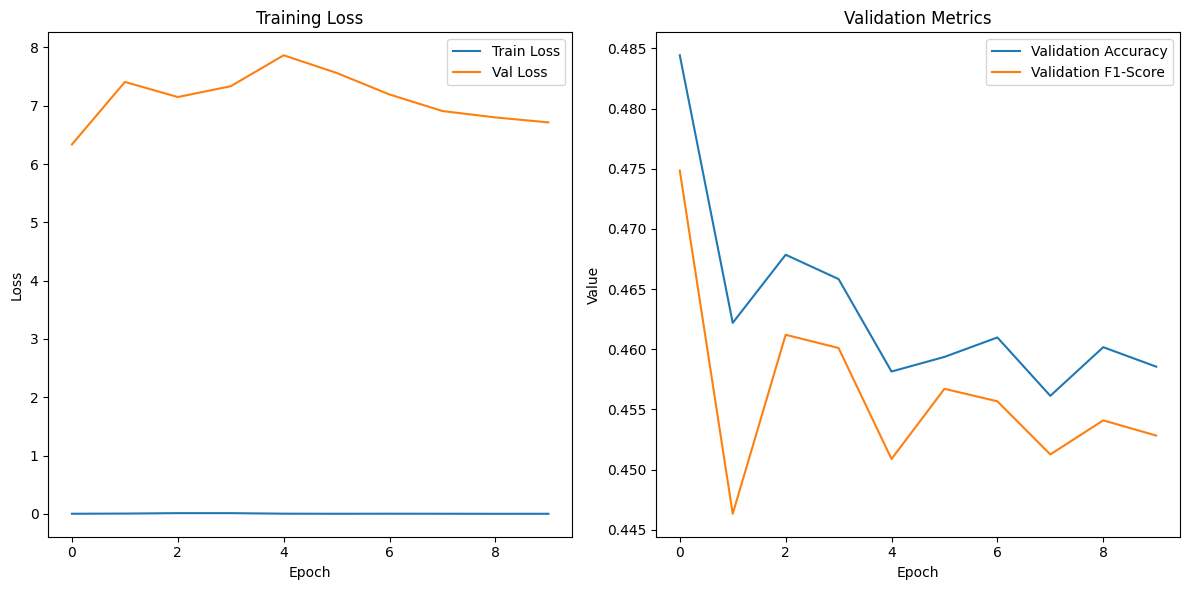

In [ ]:
# Визуализация

visualize_model_results(train_losses, val_losses, val_metrics)

In [ ]:
# Сохраняем результаты первого теста архитектуры с batch_size = 128
save_log_model_results("unet_base_batch_128_size.log", train_losses, val_losses, val_metrics)

Лог результатов сохранен в файл unet_base_batch_128_size.log


In [ ]:
# Теперь для 256 батчей.

batch_size = 256

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Запуск обучения с 256 батчами. Пример, чтобы посмотреть на изменение
train_losses, val_losses, val_metrics = train_and_evaluate(unet, train_loader, val_loader, num_epochs=10, lr=lr) 

# По аналогии сохраняем предсказания
output_file = "test_predictions_image256.csv"
predict_and_save(unet, test_loader, output_file)

Epoch 1/10, Train Loss: 0.0012, Val Loss: 7.2521, Val Acc: 0.4654, Val Prec: 0.4604, Val Recall: 0.4654, Val F1: 0.4584
Epoch 2/10, Train Loss: 0.0010, Val Loss: 6.2079, Val Acc: 0.4695, Val Prec: 0.4779, Val Recall: 0.4695, Val F1: 0.4680
Epoch 3/10, Train Loss: 0.0011, Val Loss: 6.9106, Val Acc: 0.4695, Val Prec: 0.4655, Val Recall: 0.4695, Val F1: 0.4580
Epoch 4/10, Train Loss: 0.0019, Val Loss: 7.8708, Val Acc: 0.4488, Val Prec: 0.4565, Val Recall: 0.4488, Val F1: 0.4426
Epoch 5/10, Train Loss: 0.0039, Val Loss: 7.2569, Val Acc: 0.4630, Val Prec: 0.4737, Val Recall: 0.4630, Val F1: 0.4576
Epoch 6/10, Train Loss: 0.0033, Val Loss: 7.6152, Val Acc: 0.4602, Val Prec: 0.4646, Val Recall: 0.4602, Val F1: 0.4522
Epoch 7/10, Train Loss: 0.0016, Val Loss: 7.2249, Val Acc: 0.4666, Val Prec: 0.4716, Val Recall: 0.4666, Val F1: 0.4643
Epoch 8/10, Train Loss: 0.0017, Val Loss: 7.6889, Val Acc: 0.4642, Val Prec: 0.4634, Val Recall: 0.4642, Val F1: 0.4578
Epoch 9/10, Train Loss: 0.0058, Val Loss

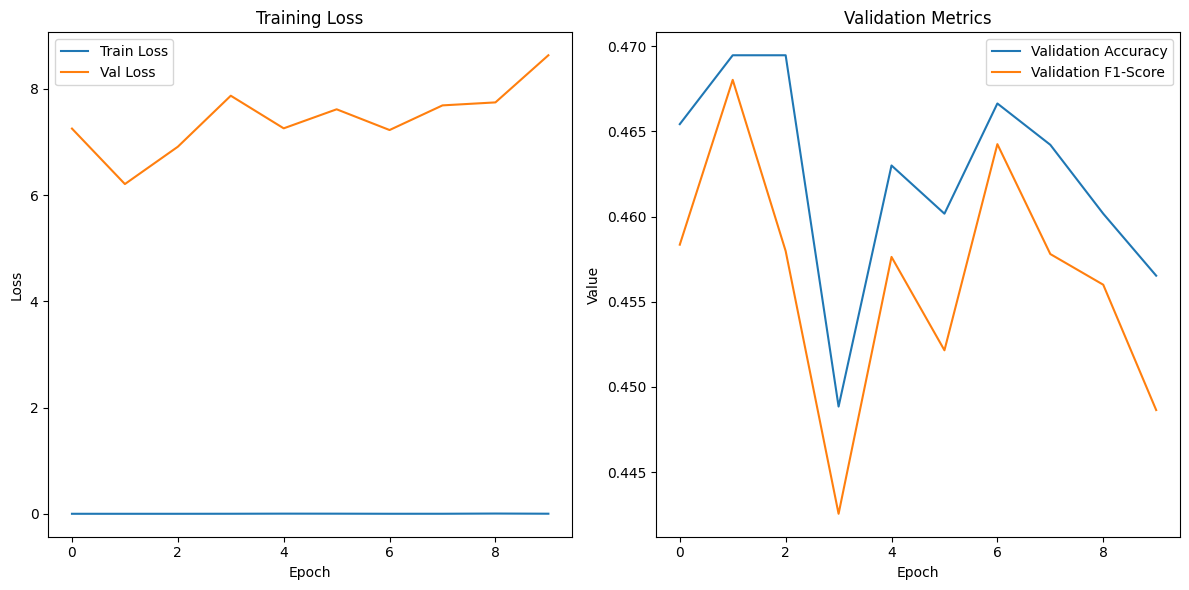

In [ ]:
# Визуализация

visualize_model_results(train_losses, val_losses, val_metrics)

In [ ]:
# Сохраняем результаты первого теста архитектуры с batch_size = 256
save_log_model_results("unet_base_batch_256_size.log", train_losses, val_losses, val_metrics)

Лог результатов сохранен в файл unet_base_batch_256_size.log


**Выводы**: По итогам можно заметить, что данная архитектура имеет довольно высокий accuracy и f1-score, однако график ошибок сигнализирует о сильном переобучении, валидационная ошибка большая, обучающая очень маленькая, что говорит о том, что модель на этапе обучения сильно преспосабливается к данным. Видимо нужно произвести какие то действия с данными, либо упростить модель.